# Test cell — notebook will be updated next

# Week 2–3: Cross-Validation, Hyperparameter Tuning, Ensembles, SHAP & Pipelines

**Audience:** Beginner → Intermediate  
**Focus:** Practical, scikit-learn-first implementations (with optional XGBoost + SHAP)  
**Datasets:** `sklearn.datasets` (Iris, Breast Cancer), plus small synthetic examples


---
## What you'll learn
1. Cross-validation: K-Fold, Stratified K-Fold, Leave-One-Out
2. Hyperparameter tuning: `GridSearchCV`, `RandomizedSearchCV`
3. Ensembles: RandomForest (+ optional XGBoost with early stopping)
4. Model interpretability with SHAP (for tree models)
5. Clean end-to-end ML Pipelines (`Pipeline`, `ColumnTransformer`) with hyperparameter search

> Tip: Run each section independently. Some optional dependencies (xgboost, shap) may need installation in your environment.


## 0) Setup & Imports

In [1]:
!pip install shap

Error processing line 1 of /opt/anaconda3/lib/python3.12/site-packages/distutils-precedence.pth:

  Traceback (most recent call last):
    File "<frozen site>", line 206, in addpackage
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named '_distutils_hack'

Remainder of file ignored
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.3/556.3 kB 1.9 MB/s  0:00:0036m-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [shap]1/2 [shap]


In [2]:

import numpy as np
import pandas as pd

from sklearn.datasets import load_iris, load_breast_cancer, make_classification
from sklearn.model_selection import (train_test_split, cross_val_score, KFold, 
                                     StratifiedKFold, LeaveOneOut, GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             confusion_matrix, classification_report, roc_auc_score)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Optional deps: xgboost & shap
try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False
    print("XGBoost not available in this environment. You can install with: pip install xgboost")

try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False
    print("SHAP not available in this environment. You can install with: pip install shap")


## 1) Cross-Validation: K-Fold, Stratified, Leave-One-Out

In [3]:

# Iris (multiclass)
X_iris, y_iris = load_iris(return_X_y=True)
clf = LogisticRegression(max_iter=200)


X_iris

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [4]:
print("K-Fold (k=5) on Iris")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores_kf = cross_val_score(clf, X_iris, y_iris, cv=kf, scoring='accuracy')
print("Scores:", np.round(scores_kf, 3), "Mean:", scores_kf.mean().round(3))

K-Fold (k=5) on Iris
Scores: [1.    1.    0.933 0.967 0.967] Mean: 0.973


In [5]:
print("\nStratified K-Fold (k=5) on Iris")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_skf = cross_val_score(clf, X_iris, y_iris, cv=skf, scoring='accuracy')
print("Scores:", np.round(scores_skf, 3), "Mean:", scores_skf.mean().round(3))


Stratified K-Fold (k=5) on Iris
Scores: [1.    0.967 0.933 1.    0.933] Mean: 0.967


In [6]:
print("\nLeave-One-Out (LOOCV) on Iris (this can be slow)")
loo = LeaveOneOut()
scores_loo = cross_val_score(clf, X_iris, y_iris, cv=loo, scoring='accuracy')
print("Mean LOOCV Accuracy:", scores_loo.mean().round(3))


Leave-One-Out (LOOCV) on Iris (this can be slow)
Mean LOOCV Accuracy: 0.967


In [7]:
scores_loo

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [8]:
# Breast Cancer (binary) with stratified CV
X_bc, y_bc = load_breast_cancer(return_X_y=True)
clf_bc = LogisticRegression(max_iter=1000)
print("\nStratified K-Fold on Breast Cancer (binary)")
scores_bc = cross_val_score(clf_bc, X_bc, y_bc, cv=skf, scoring='accuracy')
print("Scores:", np.round(scores_bc, 3), "Mean:", scores_bc.mean().round(3))


Stratified K-Fold on Breast Cancer (binary)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Scores: [0.947 0.912 0.947 0.939 0.965] Mean: 0.942


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
print("Scores:", np.round(scores_bc, 3), "Mean:", scores_bc.mean().round(3))

Scores: [0.947 0.912 0.947 0.939 0.965] Mean: 0.942


## 2) Hyperparameter Tuning: GridSearchCV & RandomizedSearchCV

In [ ]:

from scipy.stats import randint

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_bc, y_bc, test_size=0.2, stratify=y_bc, random_state=42)

In [ ]:
# A) Logistic Regression: GridSearch over C
param_grid_logit = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs']}
grid_logit = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_logit, cv=5, scoring='accuracy', n_jobs=-1)
grid_logit.fit(X_train, y_train)
print("LogisticRegression best params:", grid_logit.best_params_)
print("CV best score:", round(grid_logit.best_score_, 3))
print("Test accuracy:", round(grid_logit.best_estimator_.score(X_test, y_test), 3))

In [ ]:
# B) Decision Tree: GridSearch on depth / min_samples_split
param_grid_tree = {'max_depth': [None, 2, 4, 6, 8], 'min_samples_split': [2, 5, 10]}
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid_tree, cv=5, scoring='f1', n_jobs=-1)
grid_tree.fit(X_train, y_train)
print("\nDecisionTree best params:", grid_tree.best_params_)
print("CV best F1:", round(grid_tree.best_score_, 3))
y_pred_tree = grid_tree.best_estimator_.predict(X_test)
print("Test F1:", round(f1_score(y_test, y_pred_tree), 3))

In [ ]:
# C) Random Forest: RandomizedSearch
param_dist_rf = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 20),
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10]
}
rand_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                             param_distributions=param_dist_rf,
                             n_iter=15, cv=5, scoring='roc_auc',
                             random_state=42, n_jobs=-1)
rand_rf.fit(X_train, y_train)
print("\nRandomForest best params:", rand_rf.best_params_)
print("CV best ROC AUC:", round(rand_rf.best_score_, 3))
y_proba_rf = rand_rf.best_estimator_.predict_proba(X_test)[:,1]
print("Test ROC AUC:", round(roc_auc_score(y_test, y_proba_rf), 3))

## 3) Pipelines + ColumnTransformer (+ tuning inside a Pipeline)

In [ ]:

# Mixed-type mini dataset
df = pd.DataFrame({
    'age': [22, 35, 58, 44, 29, 63, 51, 40, 33, 27],
    'balance': [1200, 5600, 23000, 11000, 3400, 54000, 16000, 9800, 7400, 2500],
    'region': ['A','B','A','C','B','C','A','B','C','A'],
    'is_vip': ['no','no','yes','no','no','yes','yes','no','no','no'],
    'churn': [0,1,1,0,0,1,0,1,0,0]
})

numeric_features = ['age', 'balance']
categorical_features = ['region', 'is_vip']

numeric_pipeline = Pipeline([('scaler', StandardScaler()),
                             ('pca', PCA(n_components=1))])
categorical_pipeline = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

pipe = Pipeline([('preprocess', preprocess),
                 ('clf', RandomForestClassifier(random_state=0))])

X_df = df.drop(columns=['churn']); y_df = df['churn']

param_grid_pipe = {
    'preprocess__num__pca__n_components': [1, 2],
    'clf__max_depth': [None, 3, 5],
    'clf__n_estimators': [50, 100]
}
grid_pipe = GridSearchCV(pipe, param_grid_pipe, cv=3, scoring='accuracy')
grid_pipe.fit(X_df, y_df)
print("Best pipeline params:", grid_pipe.best_params_)
print("CV best accuracy:", round(grid_pipe.best_score_, 3))


## 4) (Optional) XGBoost with Early Stopping

In [ ]:

if 'HAS_XGB' in globals() and HAS_XGB:
    X_tr, X_val, y_tr, y_val = train_test_split(load_breast_cancer(return_X_y=True)[0],
                                                load_breast_cancer(return_X_y=True)[1],
                                                test_size=0.2, stratify=load_breast_cancer(return_X_y=True)[1], random_state=42)
    xgb_clf = xgb.XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=3,
        subsample=0.9, colsample_bytree=0.9,
        objective='binary:logistic', eval_metric='logloss', random_state=42
    )
    xgb_clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=20, verbose=False)
    print("Best iteration (trees):", getattr(xgb_clf, "best_iteration", None))
    y_pred = xgb_clf.predict(X_val)
    print("XGBoost validation accuracy:", round(accuracy_score(y_val, y_pred), 3))
else:
    print("XGBoost skipped (package not installed).")


## 5) Model Interpretability with SHAP (summary plot + single-prediction force plot)

In [10]:

# Fit a RandomForest for interpretability demo
X_bc, y_bc = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_bc, y_bc, test_size=0.2, stratify=y_bc, random_state=42)
rf_int = RandomForestClassifier(n_estimators=200, random_state=0).fit(X_train, y_train)

In [21]:
X_bc.shape

(569, 30)

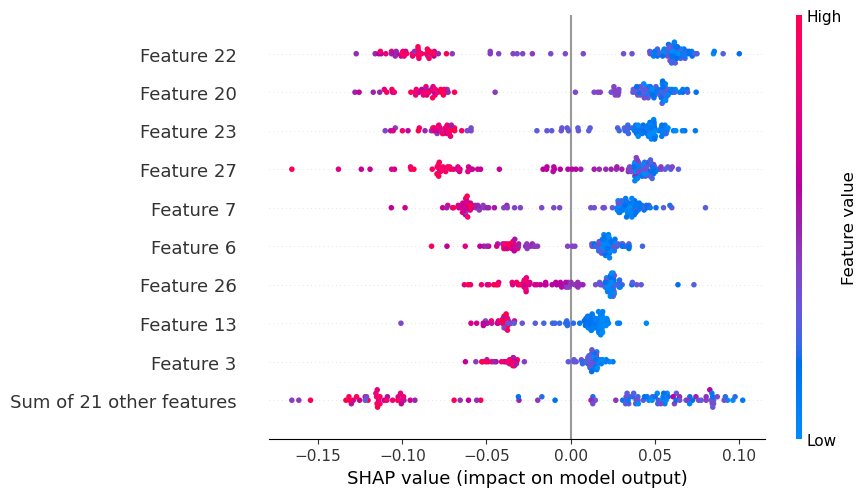

In [17]:
# Try to import SHAP
try:
    import shap
    HAS_SHAP = True
except ImportError:
    HAS_SHAP = False
    print("SHAP skipped (package not installed).")

if HAS_SHAP:
    # Create explainer with just the model
    explainer = shap.TreeExplainer(rf_int)
    
    # Calculate SHAP values for test set
    shap_values = explainer(X_test)
    
    # Get feature names
    feature_names = load_breast_cancer().feature_names
    
    # Initialize JavaScript for SHAP plots
    shap.initjs()
    
    # For binary classification, use shap_values[:, :, 1] to get the positive class
    # Or use shap_values[:, :, 0] for the negative class
    shap.plots.beeswarm(shap_values[:, :, 1])
else:
    print("SHAP skipped (package not installed).")